In [2]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import utils
import stats
from functools import reduce
import operator
from scipy.stats import norminvgauss as inv
from scipy.stats import gaussian_kde as kde
from tqdm import tqdm
from pprint import pprint as pp
import re
from collections import Counter

# various helper functions

In [31]:
def plot_posterior_estimates(trace):
    """ Plot posterior parameter distributions, i.e., P(parameter=value | data)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
    
def plot_posterior_predictive_checks(model, trace, size=1000):
    """ Plot (hist) predictions of estimand (based on parameter posteriors) against the observed 
    """
    
    # get estimand predictions based on param posteriors
    with model: 
        post_pred: arviz.data.inference_data.InferenceData = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        # don't add to trace
            
    # for each estimate record (predictions, observed) for each estimand
    d = {}
    n = len(post_pred.posterior_predictive)
    for i, name in enumerate(post_pred.posterior_predictive):
        
        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[name].dims
        p: np.ndarray = np.random.choice(post_pred.posterior_predictive[name].stack(sample=p_dims).to_numpy(), size, replace=True)
            
#         p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))  
            
        o: np.ndarray = post_pred.observed_data[name].to_numpy()
        d[name] = (p,o)  # (predicted, observed)
        
    # plot observed vs predicted for each estimand
    fig, axs = plt.subplots(n)
    fig.tight_layout(h_pad=4)
    for i, name in enumerate(post_pred.posterior_predictive):

        if n > 1:
            plt.sca(axs[i])
        else:
            pass
        plt.hist([d[name][0], d[name][1]], label=['predicted', 'observed'], density=True)
        plt.xlabel(name)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)
        
    return d
    
def plot_posterior_estimates_contrast(trace, pairs=[], kind='kde'):
    """ For each param1, param2 pair in 'pairs' ...
            plot distribution of corresponding (param1 - param2) estimates.
            
        Note: also return each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    contrasts = []
    
    fig, axs = plt.subplots(1)
    fig.tight_layout()
    
    # plot contrasts
    for i, (x,y) in enumerate(pairs):
        
        pc = (trace.posterior[x] - trace.posterior[y]).stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        az.plot_dist(pc, color=f'C{i}', kind=kind, label=f'{x}-{y}')
        
        contrasts.append(pc)
        
    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()
        
    return contrasts
        
        
def plot_posterior_predictions_contrast(model, trace, pairs=[], size=1000)->list:
    """ For each estimand1, estimand2 'pair' in 'pairs' ...
            plot the distribution of corresponding (estimand1 - estimand2) samples
    
        Note: also return each contrast. I.e., returned[i] is a contract dist. corresponding to pairs[i]
        where returned 1 is a 1D numpy array
    """
    
    returned=[]
    
    # get posterior predictions
    with model:
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
    preds = {name: post_pred.posterior_predictive[name] for name in post_pred.posterior_predictive} 
    # NOTE: e.g., preds[var].shape=(chains, draws, datapoints)
        
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()
    
    
    for i, (name1, name2) in enumerate(pairs):
        
        # if more than one plot, set current
        try:
            plt.sca(axs[i])
        except:
            pass
        
        # Note xarray of dims (chain, draw, m) - x array of dims (chain, draw, f) would yield an
        # an array of dims (chain, draw, m, f) i.e., all possible differences accross all m,f permutations for a draw, chain combo
        # this becomes very slow for larger samples ... hence we just randomnly select some ... and take the diff.
        
        # plot contrast
        sample1 = np.random.choice(preds[name1].stack(sample=(preds[name1].dims)).to_numpy(), size, replace=True)
        sample2 = np.random.choice(preds[name2].stack(sample=(preds[name2].dims)).to_numpy(), size, replace=True)
        ppc = sample1 - sample2
        az.plot_dist(ppc, color='k', plot_kwargs=dict(linewidth=3))
        plt.xticks(rotation=90)
        
        plt.xlabel(f"({name1}-{name2})\nposterior prediction contrast")
        plt.ylabel("density")
        plt.legend()
        
        returned.append(ppc)
        
    return returned

def compat_interval(d: np.ndarray, CI=0.89)->tuple[float]:
    lb = (1-CI)/2
    ub = CI+lb
    return '%.3E' % np.quantile(d, lb), '%.3E' % np.quantile(d, ub)

# Analysis

### import the American Literature Fiction corpus

In [6]:
# data = pd.concat([pd.read_csv('quotes/quotes_PS.csv'), pd.read_csv('quotes/quotes_PR.csv')])
data = pd.read_csv('extract_project_gutenberg_quotes/quotes_en_PS_fiction_020524.csv')
data.info()
data.iloc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6690793 entries, 0 to 6690792
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   person      object
 2   manner      object
 3   quote       object
 4   book        int64 
dtypes: int64(2), object(3)
memory usage: 255.2+ MB


Unnamed: 0                                0
person                            Williston
manner                                 Said
quote         I Take it I am the One Wanted
book                                  41534
Name: 0, dtype: object

In [7]:
### what quotations are attributed to the speaker containing 'negro'?

In [36]:
for target in ['negro']:
    
    persons = [person for person in data.loc[data.loc[:,'person'].isna()==False, 'person'].values if target in person or target.capitalize() in person]
    display(len(persons))
    for person in set(persons):
        display(person)
        display(data.loc[data.loc[:,'person']==person, 'quote')

950

'negro rolled'

831010    To camp-meetin', Mass Hildreff. I hez your per...
Name: quote, dtype: object

'<<negro G>>'

1447732    Ah's about ready to lose control, myself! Dat ...
1447747    Come on! It's a impossibility to scare me any ...
Name: quote, dtype: object

'negro earnestly'

4144717    Oh, I won't come. Not as long as dat giant am ...
6102380                                  'Deed, sah, dere IS
Name: quote, dtype: object

'<<submerged negroes>>'

3988666    You's all Baptis' now.
Name: quote, dtype: object

'old Negro'

3877706    Right ovah thaih
Name: quote, dtype: object

'stalwart negro'

3064073    I wuz des worryin' 'bout dat 'while ago
Name: quote, dtype: object

'<<negro had>>'

2559742    I see, sir, I've woke up the wrong passenger. ...
Name: quote, dtype: object

'<<negro boy>>'

633060     who's a-gwine to take k'yar o' you ef Sam ain'...
5929990    we kin stop yonda at ole M'sie Jean Ba's an' f...
Name: quote, dtype: object

'<<negro smiling>>'

6108773    Is yer man agwine to git lected?
Name: quote, dtype: object

'pertinacious negro'

770375     Well, now, I be surprise, Miss Dus! How you ca...
1864861    Well, now, I be surprise, Miss Dus! How you ca...
Name: quote, dtype: object

'negro woman'

1889332    You's sure goin'!
Name: quote, dtype: object

'<<negro who>>'

2396689                          Watch out, Mistoo Tah-bawx!
2396690                      dat boat dess lousy wid snake'!
3716183    here you see blossoms and ripe fruit together ...
3716184    the leaves when crushed in the palm exhale a d...
Name: quote, dtype: object

'frightened negro'

1236205              Don't know what dat all means, boss
1464929    He ax me w'at make de niggers stay in slave'y
1697002                                What's de matter?
2095258              Don't know what dat all means, boss
3735605             Did you feel dat, too, Marse Warren?
5279872                     Will we bofe git on de hoss?
Name: quote, dtype: object

'<<stalwart negro>>'

3064074    I 'speck I'd be like de ole sheep you hear tal...
Name: quote, dtype: object

'negro in'

1856558                  Now, Mars. George
5128660                 Go 'way, Marse Dan
5128703    I'se hyer, Marse Dan, I'se hyer
5645114                      Yes, marster!
Name: quote, dtype: object

'<<negro suspiciously>>'

6108745    How menny shurrufs is yer agwine to hab in dis...
Name: quote, dtype: object

'negroes of'

1398243    Constitution" to which his men had sworn alleg...
Name: quote, dtype: object

'desperate negro'

1624842    Afo' de Lawd, Boss
2097015    Afo' de Lawd, Boss
Name: quote, dtype: object

'negro despairingly'

1624717    Afo' God, I don't know what tuh do, or wha tuh go
2096891    Afo' God, I don't know what tuh do, or wha tuh go
Name: quote, dtype: object

'<<Negro>>'

2536468                   I sure would have remembered, sah,
2536469    Dey been havin' a big game on between Mr. Char...
3269789    Bags on the cart, Mr. Stern. Patients to the l...
3269795    That's at five. You're late for milk and cooki...
3269805       One is to obey all rules here on the premises.
3462696    to keep them within this room, but do not fear...
3462771    Beyond this next turn we will see it a few pac...
3832245    Piquette was your reason for voting for war, i...
4042911    De rails is done gone twist wid de shakes. Dey...
4042921    but I'se been a tough one befo' Freedom. I sol...
4042929    I kin run faster'n you, honey! Goramercy, _dar...
4611427    Rule number one: assume the simplest; that inc...
4611518                            Watch out there, big boy!
4612332                  You know and I want you to tell me!
4653864    Industrialization, education, can be a geometr...
4717346    Dinner'll be ready in about half an hour, Mrs....
5076872                 

'simple negro'

6109951    I wonder what mars judge do mean?
Name: quote, dtype: object

'<<pertinacious negro>>'

770376     Masser Corny was little ole, p'r'aps, if he li...
1864862    Masser Corny was little ole, p'r'aps, if he li...
Name: quote, dtype: object

'<<desperate negro>>'

1624843    I jest can't l'arn no mo', now, nohow. 'Deed I...
2097016    I jest can't l'arn no mo', now, nohow. 'Deed I...
Name: quote, dtype: object

'negro who'

145419               Why, he's whitaw dan his white brudder!
145426     Yah-hah! an' ob de lashes dat you gib dis dam ...
2396688                    Been struck by lightnin' sim like
3716182    I know it; so in revenge I'm going to spoil yo...
Name: quote, dtype: object

'<<negro despairingly>>'

1624718    If yo' leab me here, I know dat ole mas'r 'll ...
2096892    If yo' leab me here, I know dat ole mas'r 'll ...
Name: quote, dtype: object

'negro started'

1015099    Fire'll be dar in less'n no time. Him nuffin t...
2456951    I am going with you to the quarters tonight," ...
Name: quote, dtype: object

'<<alarmed negro>>'

2523717    he know eberyting.
Name: quote, dtype: object

'negro hopelessly'

1624714    But whah'm I tuh go?
2096888    But whah'm I tuh go?
Name: quote, dtype: object

'Negro Dialect. By A. C. Gordon'

2645301    BEFO' DE WAR.
Name: quote, dtype: object

'negro scout'

5752495    _Caramba!_ I thought it was, my captain!
Name: quote, dtype: object

'<<faithful negroes>>'

3063947    I'm mighty glad dat Chris'mas is so nigh. De c...
Name: quote, dtype: object

'negro'

6074                                    Howdy, Marse Stephen
23775                                             None, suh?
23777                                              Well, suh
23781                                     Dey won't find 'em
23868                                       I'm coming, suh!
                                 ...                        
6674856                                       No, sah, neber
6674905           Now, Marse Houghton, wot you gwine ter do?
6678024                              A letter from Massa Tom
6678312    Oh, Miss Ruth, old Pomp never will leave ye, n...
6678318                                 I'll show ye, missus
Name: quote, Length: 306, dtype: object

'<<negroes called>>'

2947122    Bass-En'
Name: quote, dtype: object

'<<Stern. The Negro>>'

3269791    Patients to my left. Bags on the cart.
Name: quote, dtype: object

'<<younger negro>>'

1389403    why you no row 'im like other folk?
Name: quote, dtype: object

'negro quarters'

3530593    Hi, thar, Rube, Tom, Dink, Eph! Wake up, you l...
Name: quote, dtype: object

'<<offended negro>>'

4647170    so long as he behave heself.
Name: quote, dtype: object

'negro gave'

2314817    dis am too good news for old black man live me...
6109007    You has got ter go ded er live, I'm er gwine t...
Name: quote, dtype: object

'faithful negroes'

3063946    I'm mighty glad," Harbert remarked, glancing a...
Name: quote, dtype: object

'negro maid'

5736565    She says come right up to her room, Miss Selah...
Name: quote, dtype: object

'negro girl'

2030125    Reckon heâs from yer home âcase he says ho...
3855171                      Madame is waiting your pleasure
4599839    Nebber you fear, Miss Sukey. I be down at Olef...
Name: quote, dtype: object

'negro boy'

633059                                     But, Mas' Baillie
660698     Oh, I've seen a sperrit--I've seen a sperrit! ...
4599410    Miss Odalite is comin', ma'am. I seen her just...
5929989                                          Ef you want
Name: quote, dtype: object

'puzzled negro'

5557116    'And-out?
Name: quote, dtype: object

'Negro Dialect'

6460699    Befo' de War.
Name: quote, dtype: object

'negro drew'

1423207    This will do," he said. "Let me out here, and ...
Name: quote, dtype: object

'other negro'

4994973    What he clumb arter?
Name: quote, dtype: object

'negro at'

5472507    Yes, seh
Name: quote, dtype: object

'Negro Dialect. By A. C. G'

3097782    =BEFO' THE WAR.=
Name: quote, dtype: object

'negro crept'

2093882    No, sah; dar certenly don't 'pear fer ter be much
Name: quote, dtype: object

'negro suspiciously'

6108744    Dats a mity heep ob promisin, white man
Name: quote, dtype: object

'<<quaking negro>>'

493446    She is the captain's wife. She is--
Name: quote, dtype: object

'old negro'

50988      Top a bit, mistis, an' I will fix de little ga...
50990                                                Dar now
51195                                    Nebber mind, missis
51208                   I don't know, but I spect it will do
51301                                        Don't cry chile
                                 ...                        
6109968    Lans saks, yung marser, dis ole nigger don't a...
6110088    Mars jedge has yu dun und sassinated my yung m...
6209345    Why, massa, him great t'ing dat-what big old m...
6209353    Ah, Massa Stranger, ye got ole Simon da! If me...
6470395                                       Mo' tam es dem
Name: quote, Length: 87, dtype: object

'<<negro earnestly>>'

4144718    Besides, I were only goin' t' count Eradicate'...
6102381                  I'll jist fetch it wid de accounts.
Name: quote, dtype: object

'<<negro at>>'

5472508    He's er frien' er mine. He is dat.
Name: quote, dtype: object

'negro doggedly'

3556376    Ef he had'n conjured me
Name: quote, dtype: object

'negro dealer'

5646071    There's the nigger that set my peep in limbo
Name: quote, dtype: object

'bewildered negro'

6321712    Bress yer, Missy Flory! _am_ yer alive!
Name: quote, dtype: object

'negro owner'

6674840    Yah, yah, so 'tis alibe
Name: quote, dtype: object

'<<frightened negro>>'

1236206    but fer de good Lawd's sake don't shove dat t'...
1464930    he ax me w'at de reason dey don't git free dey...
1697003                        Who done sumfin to yo', boss?
2095259    but fer de good Lawd's sake don't shove dat t'...
Name: quote, dtype: object

'negro had'

2559741    Cunnel" travelling twenty miles through the te...
3261802                                               clouds
Name: quote, dtype: object

'negro intelligently'

1874209    Yes, suh
Name: quote, dtype: object

'negro village'

2763962    quarters
Name: quote, dtype: object

'terrified negroes'

6109516    Kuklux! Kuklux!
Name: quote, dtype: object

'negro to'

3287808    Dere he come
Name: quote, dtype: object

'astonished negro'

2560019    Lor bress me, Massa K----, am dat you?
Name: quote, dtype: object

'wealthiest Negro'

2732611    No
Name: quote, dtype: object

'negro replied'

6110126    Sartainly, yung missis
Name: quote, dtype: object

'<<negro slowly>>'

2729467    he hisself won't go nowhere; but some bressed ...
Name: quote, dtype: object

'negro Wiggins'

6109441    dat dar secesh's mind is a puryfied wanderin,"...
Name: quote, dtype: object

'negro smartly'

6109121    Seed him down de crick
Name: quote, dtype: object

'negro below'

4873961    Me, Neb; Jim Lincum
Name: quote, dtype: object

'giant negro'

4629404    Very well, I reckon I must do as yo' say
Name: quote, dtype: object

'<<negro as>>'

131072             and he'll find de road outside fo' yoh.
5741979    don't--don't--if dem's home guards we will be--
Name: quote, dtype: object

'negroes'

295381                                          white trash.
2665907                               She loves her _candio_
3238536    God bless you, my dear wife," he whispered; an...
5932452                                          Coon, coon!
6109440                                           Ha, Ha. Ha
Name: quote, dtype: object

'<<negro Wiggins>>'

6109442    Ef dat ar white man mak eny mo sturbance, we's...
6109443    Twenty thousand----twenty-five thousand----onc...
Name: quote, dtype: object

'<<negro gloomily>>'

2456927    What foh den did you drill us to use dem rifle...
Name: quote, dtype: object

'superstitious negro'

5729740    What dat?
Name: quote, dtype: object

'negroes more'

4600794    before the war"--or "befo' de wo
Name: quote, dtype: object

'negro coachman'

4908052    Dar's yar Presidio!
Name: quote, dtype: object

'<<negro man>>'

1240126    whar ole miss?
Name: quote, dtype: object

'scandalized negro'

3782314    Well, for th' LANDS sake!
Name: quote, dtype: object

'<<negro quarters>>'

3530594    Yes, suh! Comin', Marstah!
3530595               holt on the day
Name: quote, dtype: object

'<<negro with>>'

547183                        Hmff--nice homey little place,
547184                      Where do you reckon we are, suh?
1624846                                new birth of freedom.
2097019                                new birth of freedom.
2560799    Ef I had de hull white race dar--right dar und...
6109418                        I spishioned yu wus a patrot.
Name: quote, dtype: object

'negro smiling'

6108772    Now yer is er a gettin down to de pint
Name: quote, dtype: object

'<<negro in>>'

1856559    ef you could see me good you wouldn't set dar ...
5128661    Gimme dat ar axe en set right down and wait tw...
Name: quote, dtype: object

'<<negro>>'

6075       I seed yo' ma yestiddy en she sutney wuz looki...
23778      dis ain't no weapon I got here.  I just carry ...
50491      for any money in dis world, and if dey wont le...
192441     Ain't I done won it fa'r and squar'? Wan't my ...
273924     Muss was _my_ prisoner; and what _good_ he do ...
                                 ...                        
6353567    Ole Mose 'im live dyar. I'll bring 'im heah, e...
6469893    now I know. You talkin' 'bout ole Mammy-Bammy ...
6488457       I tell you, Missy Holland, dat gal a deep one.
6674846                       She'm won' float anoder minit!
6674857    de boat swamp in two mi nit if I put 'bout in ...
Name: quote, Length: 201, dtype: object

'<<negro crept>>'

2093883    'ceptin' dat boat.  Dar ain't no boat 'round y...
Name: quote, dtype: object

'negro bobbed'

2031098    They done call him Mr. Camel, or Camlet, or su...
Name: quote, dtype: object

'negro porter'

793559               Yes, sir
1423128    This is Brookfield
Name: quote, dtype: object

'<<negro below>>'

4873962    You told me ef I heard any news over my way te...
Name: quote, dtype: object

'negro with'

50356                                            Yes, mistis
452335                                              Yas, suh
547182          Lord, I'm sure thankful to be with you, suh!
1624845                             Yes, Boss. 'Deed I would
2097018                             Yes, Boss. 'Deed I would
2395890                                        Dass so, boss
2456919              I reckon they won't try any games on me
2560402    Aunt Lucy say ma'am am an angel, sar, and it a...
2560798       It am slavery, sar! Shouldn't we be contented?
5234312    I reckon you're going to have about what you w...
6109417                         Yu sprises me, missus Jonsin
Name: quote, dtype: object

'<<negro started>>'

2456952    The sulphur you smelled just now, Cato, was th...
Name: quote, dtype: object

'poor negro'

134817    And I sez Amen to that! Oh, Marser! Oh, Missus...
Name: quote, dtype: object

'knowing negro'

2514345    Yes, sar
Name: quote, dtype: object

'<<startled negro>>'

5118608    _Rise up?_ Sweet lan' o' libuhty! I wondeh whu...
Name: quote, dtype: object

'negro held'

5280210    Oh, dat's de difference, am it?  Well, den, I ...
Name: quote, dtype: object

'<<negro coachman>>'

4908053    and dar's yar Wash'woman's Bay!
Name: quote, dtype: object

'<<other negro>>'

4994974    hit's mighty dangersome gittin' up trees when ...
Name: quote, dtype: object

'negro gloomily'

2456926    You said we was to pertect ourse'fs, sah
Name: quote, dtype: object

'negro man'

1240125    Look h'yar Letty
Name: quote, dtype: object

'negro threw'

4769012    Oh, de good Lawd!
Name: quote, dtype: object

'negro driver'

5115869    We done git back, Mistis
Name: quote, dtype: object

'negro G'

1447731                     He's got company!
1447746    Man, you's got more complications!
Name: quote, dtype: object

'negro slowly'

2729466    When dis old brack man dies
Name: quote, dtype: object

'negro spoke'

1015070    'Sert you? Cudjo no 'sert you.
Name: quote, dtype: object

'offended negro'

4647169    A black man so good as white, Miss Sally
Name: quote, dtype: object

'aged negro'

4525241                                    Massa Tom
5118944    Been some monkey business done round yere
Name: quote, dtype: object

'negro indignantly'

547097    Say!
Name: quote, dtype: object

'<<negro scout>>'

5752496    Better be a crab than a Cuban in these days.
Name: quote, dtype: object

'negro groaned'

3735327    Yassir
Name: quote, dtype: object

'submerged negroes'

3988665    I see my Jesus!"  When she said this a negro, ...
Name: quote, dtype: object

'<<negro owner>>'

6674841    Young Marse Houghton sail dat boat, an' he bea...
Name: quote, dtype: object

'<<negro groaned>>'

3735328    and I'd jest as lieve be back in Meadow Green....
Name: quote, dtype: object

'little negro'

1125131    Yes. It is to be my post in the game which wil...
3956510                                He done jest said it!
5117119    Wasn't the children of Israel commanded to spi...
5117237                                             Yes, suh
5117365                                           Sutny did!
5117562                                      Do I knows him!
5118432                                          Sutny will!
5118521                                                 Boss
6109114                                         Who made me?
6109158                                     James, come here
Name: quote, dtype: object

'negro from'

1013832    This way, Carl, if you want some of the right ...
Name: quote, dtype: object

'<<negro could>>'

1020912    Was you on the Harvard football team, Siner? G...
Name: quote, dtype: object

'negroes called'

1430140    charmber-do'
2947121        West-En'
Name: quote, dtype: object

'negro as'

131071                           Just give him his haid, sah
2456950    It must have struck somewhere, sah, shuah! Deh...
5741978                                      Oh! Lord! massa
Name: quote, dtype: object

'<<little negro>>'

3956511    He done jest said it! 'Cinnamon Seed an' Sandy...
5117238                                        Quite a many.
5117366          But they'll never git us to lick the spoon!
5117563    I knows him well 'nough to wish yo' hadn't 'vi...
5118433                                At's bes' thing I do!
5118522    I don' wish nobody no hard luck, but if somebo...
6109159           What is the matter, James, with your face?
Name: quote, dtype: object

'surprised negro'

188792    Why, Marse Malden, I 'spec
Name: quote, dtype: object

'<<wealthiest Negro>>'

2732612    I've quit going anybody's bond. I don't think,...
Name: quote, dtype: object

'<<simple negro>>'

6109952    Hit pears lak his mind is a purified a wonderi...
Name: quote, dtype: object

'negro guardedly'

3478596    How yo' get here, Mas'r Ca'ington?
Name: quote, dtype: object

'<<excited negro>>'

2559740    why, didn't he stay at Captin B----'s, wid de ...
Name: quote, dtype: object

'<<negro dealer>>'

5646072    but even he shall go past to-day. This accurse...
Name: quote, dtype: object

'weeping negro'

1856668    The carriage goes smoothly along here," she sa...
Name: quote, dtype: object

'quaking negro'

493445    She?
Name: quote, dtype: object

'negro comedian'

3797739    What?
Name: quote, dtype: object

'alarmed negro'

2523716    Leab it to Massa Jone
Name: quote, dtype: object

'<<aged negro>>'

4525242                         can't we git away from heah?
5118945    Been a li'l night walkin', mebbe. Boy, bring o...
Name: quote, dtype: object

'excited negro'

2559739    Who told me so?
Name: quote, dtype: object

'Negro'

978680     Why hello, Calvin, is that you?" "Yes, sah, Ma...
1137549    Crackers" always fight coloured folks! Never h...
2536467           No, sah--no, sah, Mr. Gray ain't been here
2731397    Negro doctors live by the patronage of their r...
2732127               Dat gal's got some speed, b'lieve muh!
3269277                              Now ole Crib fix you up
3269788                                            Very good
3269794                                There'll be no dinner
3269799                                 That's what he claim
3269804                       Thank you for all your trouble
3462695                                      I will help you
3462770                                  We are not very far
3832244    Even if you were a psychologist instead of a g...
4042910                                   De track's busted!
4042920                                      I'se an ole man
4042928                                 Gib 'em to me, sonny
4611426    There are an 

'<<negro principal>>'

3323000    I wish your boy to attend my school.
Name: quote, dtype: object

'negro principal'

3322999    Madam
Name: quote, dtype: object

'negro hurried'

3683855    No, _suh_! Mah Missey done say Ah talk too much.
Name: quote, dtype: object

'negro could'

1020911    Aw, is that you, Siner?
Name: quote, dtype: object

'<<negro doggedly>>'

3556377    he couldn't 'er done it.
Name: quote, dtype: object

'<<negro threw>>'

4769013    Dat sutt'nly am my outfit! Dat am Massa Waite ...
Name: quote, dtype: object

'startled negro'

2456947    Did it strike anything, sah?
5118607                      Good news!
Name: quote, dtype: object

'<<old negro>>'

50989      Dis stuff will bring her to. Don't be afeard, ...
50991      did not I tell you dat de sweet little child w...
51196      De chile is gone to heaben, whar it wont suffe...
51302            Your mammy will come back one of dese days,
51303      poh chile, I will take care ob you until your ...
51475      you tell him dat I want to see him, but don't ...
51482      He is one ob de best children I eber had takin...
51508                                   dat's de berry name!
51520      she look bery bad and sorrowful like, aldough ...
295570     It's gwine be mighty hot about yer, an' I dunn...
605800                                           Going over?
1014112    Carl's forgot his English, and don't know nuff...
1014267    Neber tink o' sech a ting, massa! He'd die, sh...
1014950    dar's a man out dar, a waitin'! Did ye see him...
1015232    I'se been lookin' for my ol' massa and my youn...
1222587                                               mammy,
1222588    Seemed to des

'little negroes'

6539615    Er ban', er ban'
Name: quote, dtype: object

'negroes express'

4087503    throw a coldness over the meeting
Name: quote, dtype: object

'Stern. The Negro'

3269790    I can handle them
Name: quote, dtype: object

'Fighting Negro'

2453865    So, you see, Bushrod, Jemimy Rennuls wus right...
Name: quote, dtype: object

'younger negro'

1389402    Why you drag 'im like ox, Irish Mike?
Name: quote, dtype: object

In [38]:
interesting = [2560402]
display(data.loc[interesting, :])
for i in interesting:
    print(str(data.at[i, 'quote']))

,Unnamed: 0,person,manner,quote,book,tokens,token_count,LL_bigrams,AvNLL_bigrams,AvNLL_bigrams_norm
2560402,881,negro with,replied,"Aunt Lucy say ma'am am an angel, sar, and it a...",22960,"[Aunt, Lucy, say, ma'am, am, an, angel, ,, sar...",19,-268.590794,14.136358,1.639681


Aunt Lucy say ma'am am an angel, sar, and it am tru--_it am tru_, sar


### Data processing of American Literature Fiction corpus

#### tokenization

In [8]:
token_patterns: re.Pattern = re.compile(
        r"(?:Mr.|Mrs.|Ms.)" + r"|"  # english salutations
        r"(?:[A-Z]\.)+"  # abbreviations type 1 (initalism), e.g., U.S.A.
        + r"|"
        + r"\d+(?:/\d+)+"  # fractions, dates
        + r"|"
        + r"[\$£]{0,1}\d+(?:\.\d+)*%*"  # numbers, currency, percentages
        + r"|"
        + r"\w+(?:-\w+)*(?:['’]\w+)*"  # words, optionally hyphenated, optionally with apostrophes
        + r"|"
        + r"\.\.\."  # elipsis
        + r"|"
        + r"[\[\].,;\"'?!():-_`]"  # misc separate tokens
        + r"|"
        + r"[•*■„~»><]",  # bad ocr tokens
        flags=re.IGNORECASE,
)

In [9]:
# Example
re.findall(token_patterns, "what's, there ,   happening ?.")

["what's", ',', 'there', ',', 'happening', '?', '.']

In [10]:
# split quotes to unigrams
f = lambda s: re.findall(token_patterns, s)
data['tokens'] = data['quote'].map(f)
data.iloc[2]

Unnamed: 0           2
person               V
manner         CHAPTER
quote           MAGGOT
book             41534
tokens        [MAGGOT]
Name: 2, dtype: object

### Estimate unigram and bigram, Laplace smoothed (MLE) probabilties based on literature domainprobabilties based on literature domain

In [11]:
# build unigram Counter wrt., whole corpus
unigrams = Counter()
for tokens in tqdm(data['tokens']):
    unigrams.update(tokens)
unigrams 

100%|█████████████████████████████| 6690793/6690793 [00:20<00:00, 331336.36it/s]


Counter({'I': 3563340,
         'Take': 18649,
         'it': 1473365,
         'am': 248972,
         'the': 3794980,
         'One': 28937,
         'Wanted': 409,
         'ON': 397,
         'THE': 4638,
         'TRAIL': 26,
         'MAGGOT': 2,
         'NOTHIN': 11,
         "'": 1119561,
         'BUT': 223,
         'A': 92525,
         'HOSS': 10,
         'THIEF': 13,
         ',': 8053339,
         'ANYWAY': 12,
         'YOU': 3832,
         'ARE': 729,
         'BOSS': 11,
         'Devil': 1136,
         'take': 168560,
         'you': 2784701,
         'Battle': 381,
         'Ax': 83,
         'but': 522674,
         "you're": 67963,
         'slow': 4952,
         "I'd": 78906,
         'give': 113754,
         'a': 2208953,
         'good': 206788,
         'deal': 24959,
         'to': 3183817,
         'sit': 20221,
         'down': 140744,
         'this': 511416,
         'minute': 24643,
         'some': 190078,
         'of': 2101358,
         'my': 706519,
  

In [12]:
# estimate MLE P(unigram) with laplace smoothing
total = unigrams.total()
V = len(unigrams.keys())
p_unigram = {unigram: (freq + 1)/ (total+V) for unigram, freq in tqdm(unigrams.most_common())}

# add in laplace smoothed for UNK
p_unigram['UNK'] = 1/V

# test
p_unigram['sailor']

100%|███████████████████████████████| 545241/545241 [00:01<00:00, 322894.15it/s]


1.3773336927113225e-05

In [13]:
# build bigram counter
bigrams = Counter()
for tokens in tqdm(data['tokens']):
    if len(tokens) >= 2:
        bigrams.update(list(zip(tokens[:-1], tokens[1:])))

100%|██████████████████████████████| 6690793/6690793 [01:30<00:00, 73956.45it/s]


In [14]:
# estimate MLE P(bigram) with laplace smoothing
total = bigrams.total()
V = len(bigrams.keys())
p_bigram = {bigram: (freq + 1)/ (total + V) for bigram, freq in tqdm(bigrams.most_common())}

# add in laplace smoothed for UNK
p_bigram['UNK'] = 1/V

p_bigram[('Help', 'me')]

100%|█████████████████████████████| 8538155/8538155 [00:17<00:00, 496636.31it/s]


7.913720526553386e-06

### Calculate Average Negative log likelihood for each quotation

In [15]:
data['token_count'] = data['tokens'].map(lambda v: len(v))

In [16]:
# log likelihood based on bigrams
f = lambda tokens: np.log([p_unigram[tokens[0]]] + [p_bigram[bigram] for bigram in zip(tokens[:-1], tokens[1:])]).sum() if len(tokens) > 0 else None
print('check: ', f(['help', 'me']), ' == ',np.log([p_unigram['help'], p_bigram[('help', 'me')]]).sum())
data['LL_bigrams'] = data['tokens'].map(f)

check:  -16.97815995474184  ==  -16.97815995474184


In [17]:
# average. NLL based on bigrams
data['AvNLL_bigrams'] = -1*data['LL_bigrams'] / data['token_count']

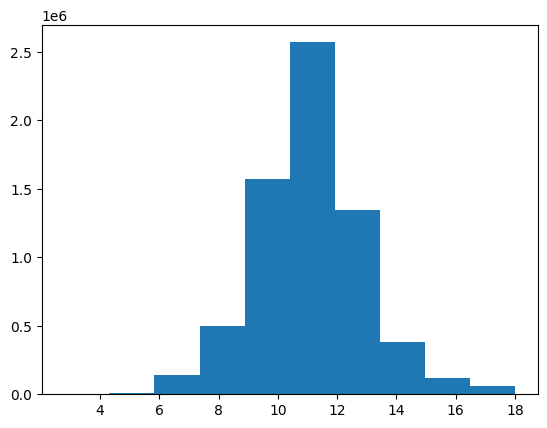

In [18]:
plt.hist(data['AvNLL_bigrams']);

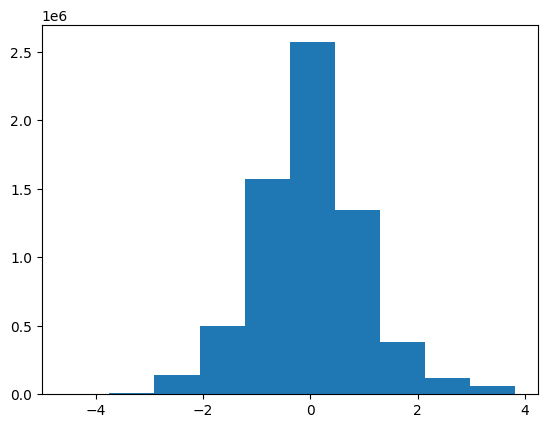

In [19]:
# normalised ...
data['AvNLL_bigrams_norm']=(data['AvNLL_bigrams'] - data['AvNLL_bigrams'].mean())/data['AvNLL_bigrams'].std()
plt.hist(data['AvNLL_bigrams_norm']);

### build a list of 'speakers' groups, each group corresponding to seed terms 

In [20]:
# collect persons of interest, by seed. E.g., seed 'man' should pick up 'Man' or 'tall man'
groups = {}
for seed in ['gentleman', 'lady', 'drunk', 'negro', 'colored', 'oriental', 'dwarf', 'cripple']: # ['drunk', 'tribal', 'servant', 'primitive', 'mulatto', 'kaffir', 'indiginous', 'half-blood', 'coolie', 'colored', 'chinaman', 'pygmy', 'cripple', 'dwarf', 'gypsy', 'native', 'negro', 'oriental', 'tribesman', 'servant']:

    groups[seed] = [person for person in data.loc[data.loc[:,'person'].isna()==False, 'person'].values if seed in person or seed.capitalize() in person]
    

In [21]:
# how many do we have?
len(groups['negro'])

950

gentleman -0.253683086511856
lady -0.205327619030637
drunk 0.6157544634130154
negro 1.3832559841415968
colored 1.3958284528902531
oriental 1.1920863215193744
dwarf 0.28727315137344966
cripple -0.04037831862875407


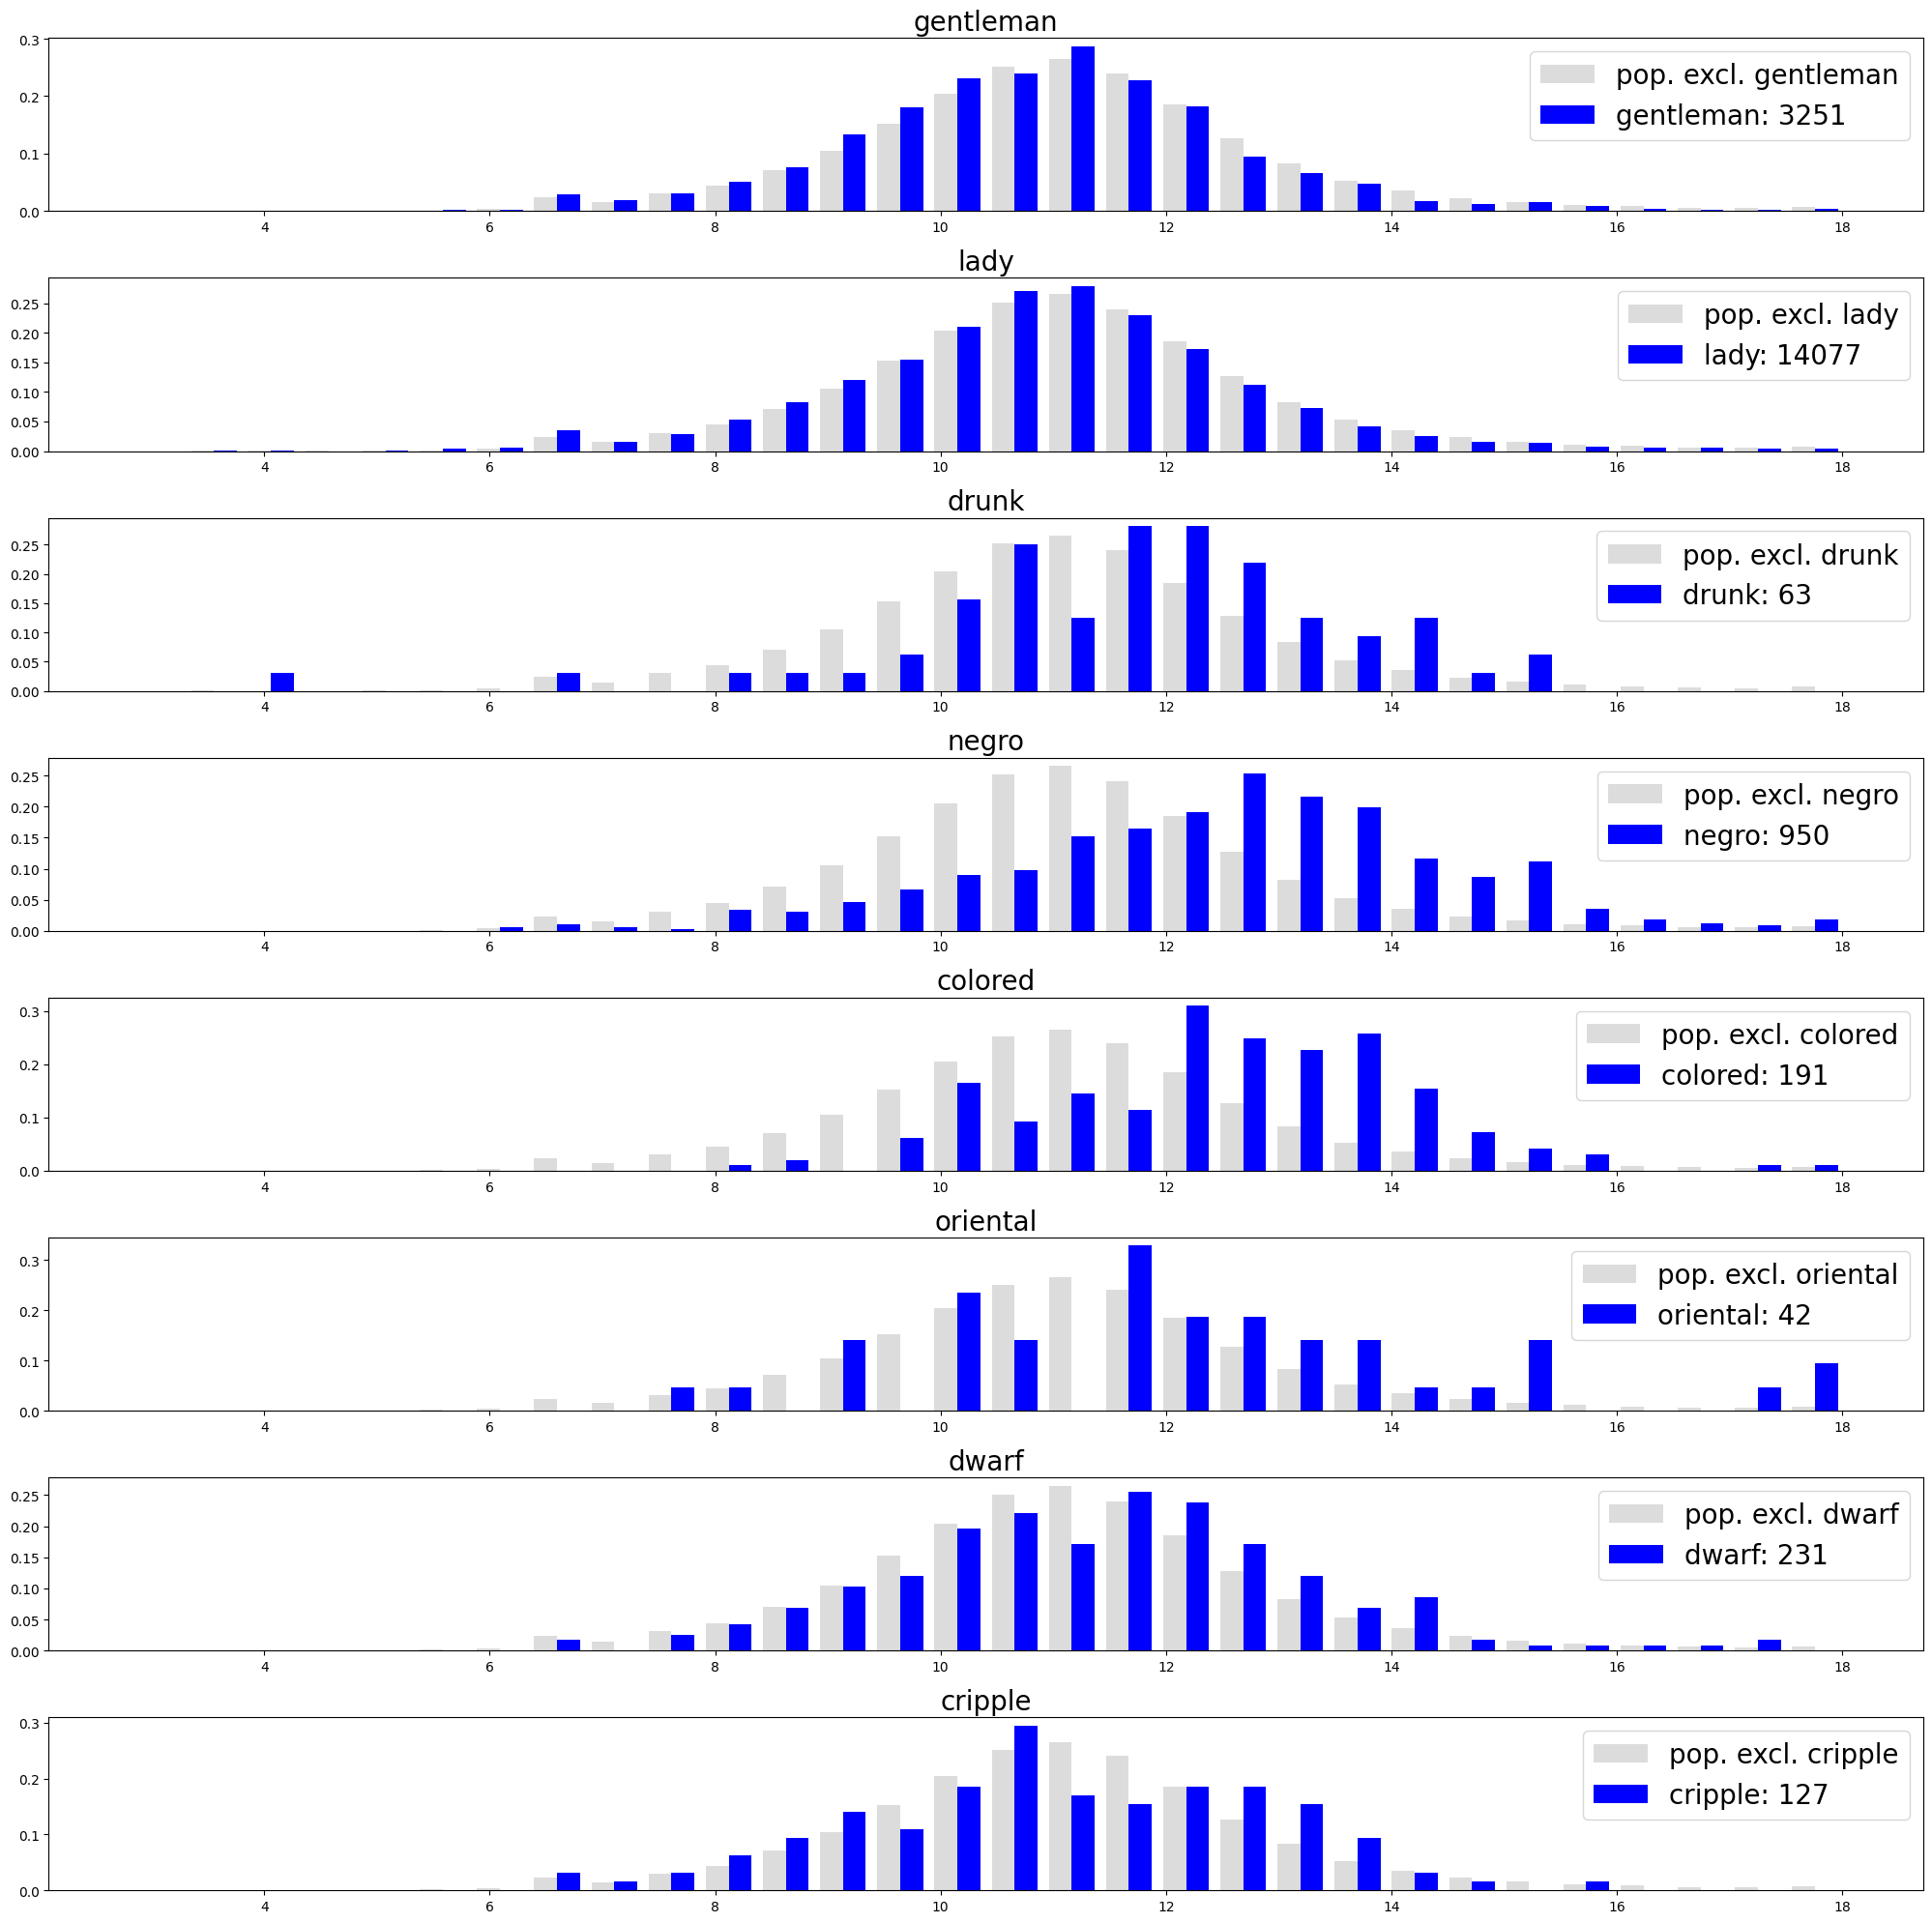

In [22]:
## what do the distributions look like?
# print('total pop=', len(data.loc[(data.loc[:,metric].isna()==False), :]))

metric = 'AvNLL_bigrams'
fig, axs = plt.subplots(len(groups.keys()), figsize=[20,20])

for i, seed in enumerate(groups.keys()):
    
    reference = data.loc[(data.loc[:,'person'].isin(groups[seed])==False) & (data.loc[:,metric].isna()==False), metric]
    candidate = data.loc[(data.loc[:,'person'].isin(groups[seed])==True) & (data.loc[:,metric].isna()==False), metric]
    
    # https://matplotlib.org/stable/gallery/color/named_colors.html
    axs[i].hist([reference, candidate], label=[f'pop. excl. {seed}', f'{seed}: {len(candidate)}'], density=True, bins=30, color=['gainsboro', 'blue']);
    axs[i].set_title(seed, fontsize=20)
    axs[i].legend(fontsize=20)
    
    print(seed, candidate.mean() - reference.mean())
    
plt.tight_layout()
plt.show()

### Bayesian Estimation: compare distribution means of:
i) distribuion of AvNLL quotes corresponding to 'terms' (e.g., oriental--related terms)
ii) distribution of AvNLL quotes corrsponding to American Literature corpus, removed of 'terms' (a random sub-sample of 100k quotes)

In [23]:
terms = groups['negro']  # CHANGE seed term to term to be analysed.

In [24]:
# 2 student t distributions
def estimator(scores, scores_):
    with pm.Model(coords={'cluster':range(2)}) as model:
       
        
        ## terms
        mu = pm.Normal('mu', 0, 5)
        nu = pm.Exponential('nu', 1)
        sigma = pm.Exponential('sigma', 1)
        pm.StudentT("S", mu=mu, nu=nu, sigma=sigma, observed=scores)
        
        ## reference
        mu_ = pm.Normal('mu_', 0, 10)
        nu_ = pm.Exponential('nu_', 1)
        sigma_ = pm.Exponential('sigma_', 1)
        pm.StudentT("S_", mu=mu_, nu=nu_, sigma=sigma_, observed=scores_)
        
        trace=pm.sample()
        
    return model, trace

scores = data.loc[(data.loc[:, 'person'].isin(terms)==True) & (data.loc[:, 'AvNLL_bigrams'].isna()==False), 'AvNLL_bigrams'].values
scores_ = data.loc[(data.loc[:, 'person'].isin(terms)==False) & (data.loc[:, 'AvNLL_bigrams'].isna()==False), 'AvNLL_bigrams'].sample(100000).values

model, trace = estimator(scores, scores_)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.


#### Posterior prediction check (visual)

Sampling: [S, S_]


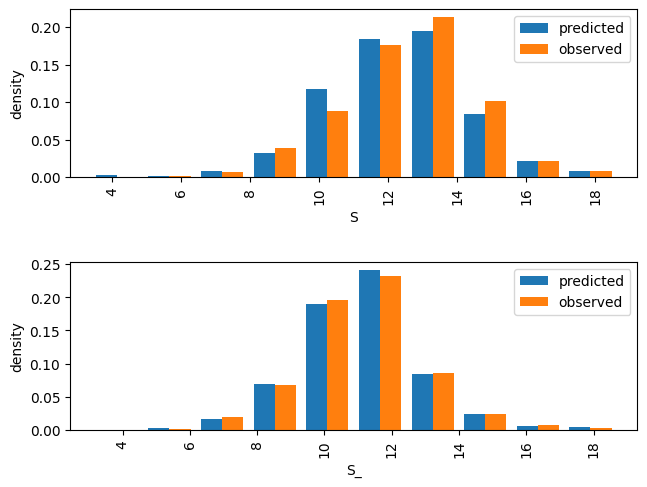

In [27]:
plot_posterior_predictive_checks(model, trace);

#### Posterior paramter estimates

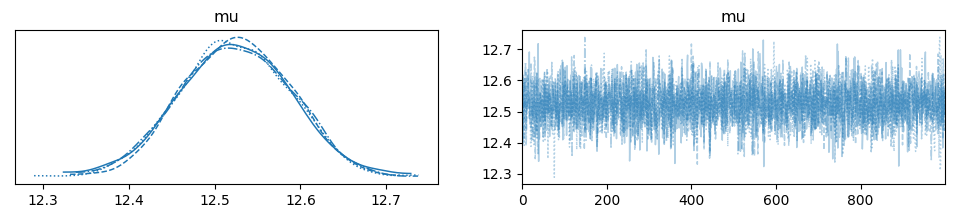

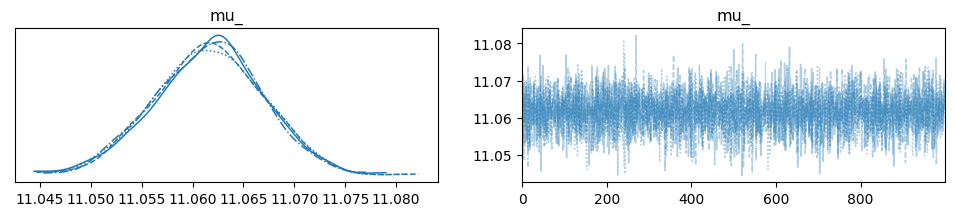

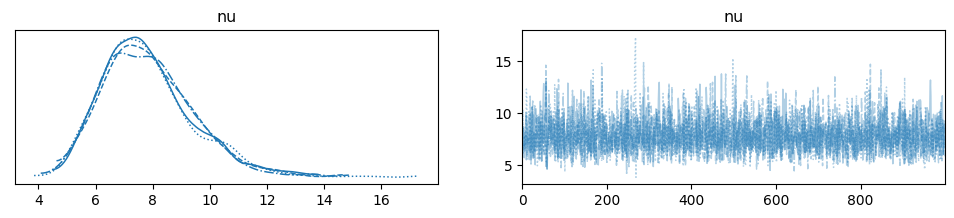

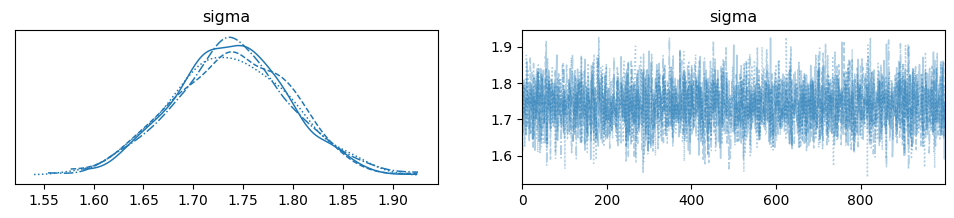

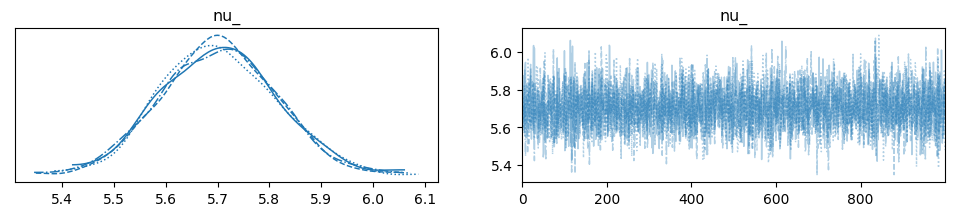

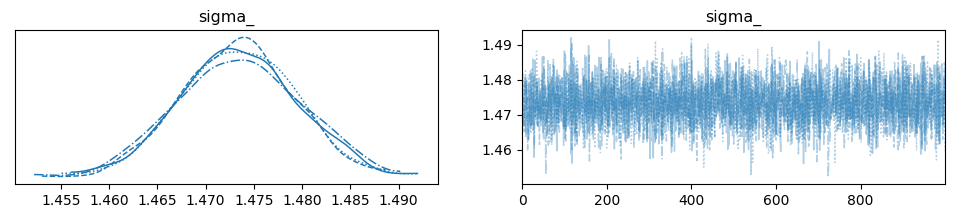

In [29]:
plot_posterior_estimates(trace);

### posterior mean contrast

('1.292E+00', '1.628E+00')

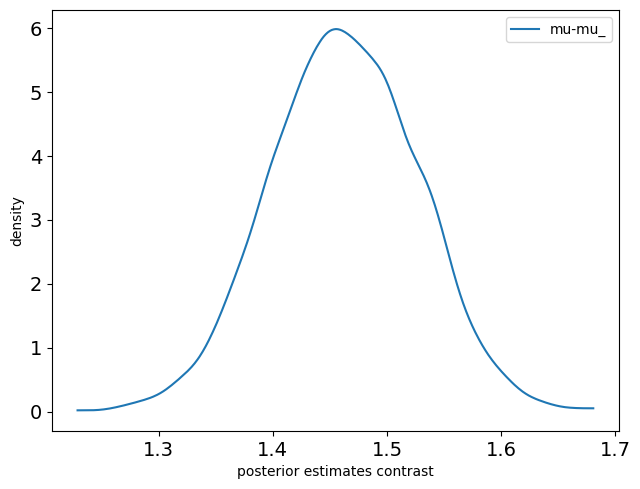

In [32]:
contrasts = plot_posterior_estimates_contrast(trace, pairs=[['mu', 'mu_']]);
display(compat_interval(contrasts, 0.99))

### plot cohen's d estimate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


('7.929E-01', '1.028E+00')

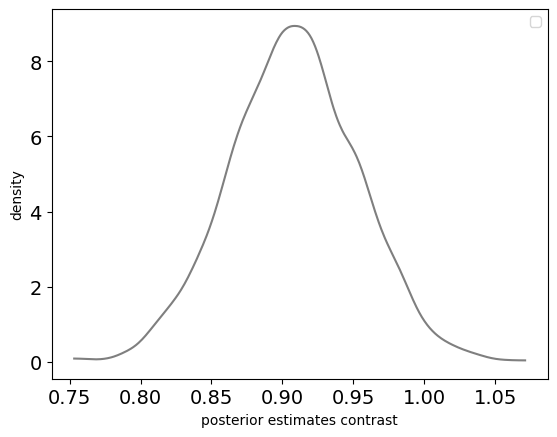

In [33]:
# size effect factor as per krutchke

# get contrasts
mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
mu_ = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
sigma_ = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

pooled = np.sqrt((sigma**2 + sigma_**2)/2)

pc = (mu-mu_)/pooled
az.plot_dist(pc, color=f'C{i}', kind='kde')

plt.xlabel(f"posterior estimates contrast")
plt.ylabel("density")
plt.legend()

compat_interval(pc, 0.99)

### Bayesian Estimation: compare distribution means of:
distribuion of AvNLL wrt., news/negro quotes

vs 

ii) distribution of AvNLL wrt., literate fiction quotes corresponding to 'terms' (e.g., oriental--related terms)
ii) distribution of AvNLL wrt., literature fiction quotes corresponding to American Literature corpus, removed of 'terms' (a random sub-sample of 100k quotes)

In [35]:
with open("quotes_news.txt", 'r') as f:
    news = [x.split('###')[0].strip('"') for x in f.readlines()]
    
news = pd.DataFrame({"quote":news})
news

,quote
0,"No, she never did no such thing neither"
1,it's sure good to see you again. I'll tell you...
2,"Yes sir; I do, but de ducks get it"
3,"Well, yes sah, you know when I go up there to ..."
4,"Judge, white fokes, couldn't you please suh ma..."
...,...
95,You have the right man.
96,It's shameful
97,Is there no place you can take me where I can ...
98,"I am Robert W. Richardson, president of the Un..."


In [36]:
# split quotes to unigrams
f = lambda s: re.findall(token_patterns, s)
news['tokens'] = news['quote'].map(f)
news.iloc[2]

quote                   Yes sir; I do, but de ducks get it
tokens    [Yes, sir, ;, I, do, ,, but, de, ducks, get, it]
Name: 2, dtype: object

In [37]:
# get length of each quote
news['token_count'] = news['tokens'].map(lambda v: len(v))

In [38]:
# log likelihood based on bigrams
p_uni  = lambda token: p_unigram[token] if token in p_unigram else p_unigram['UNK']
p_bi  = lambda token: p_bigram[token] if token in p_bigram else p_bigram['UNK']
f = lambda tokens: np.log([p_uni(tokens[0])] + [p_bi(bigram) for bigram in zip(tokens[:-1], tokens[1:])]).sum() if len(tokens) > 0 else None
print('check: ', f(['help', 'me']), ' == ',np.log([p_uni('help'), p_bi(('help', 'me'))]).sum())
news['LL_bigrams'] = news['tokens'].map(f)

check:  -16.97815995474184  ==  -16.97815995474184


In [39]:
# average. NLL based on bigrams
news['AvNLL_bigrams'] = -1*news['LL_bigrams'] / news['token_count']

#### Compare negro quotation in news VS. literature quotations in 'population removed of negro'

(array([[1.20824775e-04, 6.78583369e-04, 1.40518231e-02, 4.86385533e-02,
         1.54086951e-01, 2.52374172e-01, 1.31769731e-01, 3.71482155e-02,
         1.19518295e-02, 6.29123796e-03],
        [0.00000000e+00, 0.00000000e+00, 1.31422384e-02, 2.62844769e-02,
         7.22823114e-02, 2.03704696e-01, 2.56273650e-01, 7.88534306e-02,
         6.57111922e-03, 0.00000000e+00]]),
 array([ 2.79391668,  4.31572745,  5.83753822,  7.35934899,  8.88115976,
        10.40297053, 11.9247813 , 13.44659207, 14.96840284, 16.49021361,
        18.01202438]),
 <a list of 2 BarContainer objects>)

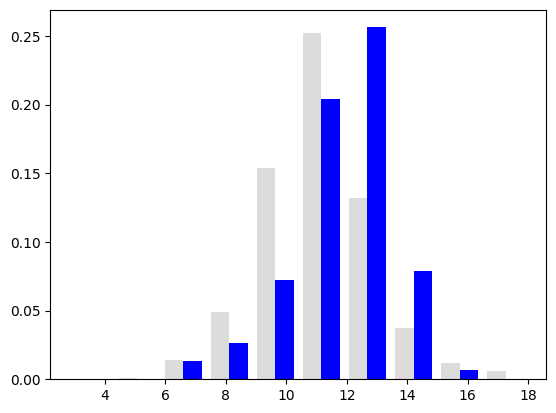

In [40]:
# plot n--word with respect to 'population removed of n word'
reference = data.loc[(data.loc[:,'person'].isin(groups['negro'])==False) & (data.loc[:,'AvNLL_bigrams'].isna()==False), 'AvNLL_bigrams']
plt.hist([reference, news['AvNLL_bigrams']], density=True, color=['gainsboro', 'blue'])

In [41]:
# bayesian estimator
def estimator(scores, scores_):
    with pm.Model(coords={'cluster':range(2)}) as model:
       
        
        ## terms
        mu = pm.Normal('mu', 0, 5)
        nu = pm.Exponential('nu', 1)
        sigma = pm.Exponential('sigma', 1)
        pm.StudentT("S", mu=mu, nu=nu, sigma=sigma, observed=scores)
        
        ## reference
        mu_ = pm.Normal('mu_', 0, 10)
        nu_ = pm.Exponential('nu_', 1)
        sigma_ = pm.Exponential('sigma_', 1)
        pm.StudentT("S_", mu=mu_, nu=nu_, sigma=sigma_, observed=scores_)
        
        trace=pm.sample()
        
    return model, trace

scores = news.loc[:, 'AvNLL_bigrams'].values
scores_ = data.loc[(data.loc[:, 'person'].isin(groups['negro'])==False) & (data.loc[:, 'AvNLL_bigrams'].isna()==False), 'AvNLL_bigrams'].sample(100000).values

model, trace = estimator(scores, scores_)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.


**plot cohen's d estimate**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


('2.990E-01', '9.071E-01')

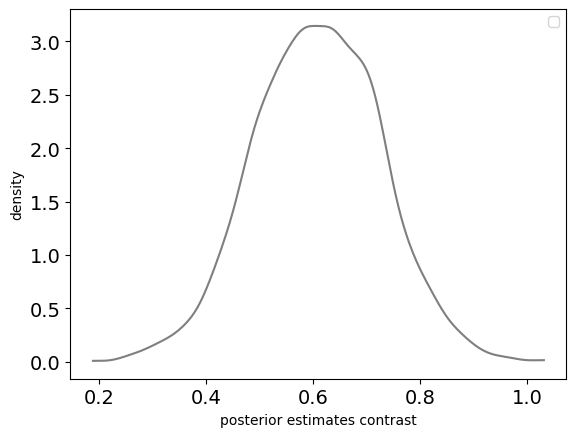

In [156]:
# size effect factor as per krutchke

# get contrasts
mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
mu_ = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
sigma_ = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

pooled = np.sqrt((sigma**2 + sigma_**2)/2)

pc = (mu-mu_)/pooled
az.plot_dist(pc, color=f'C{i}', kind='kde')

plt.xlabel(f"posterior estimates contrast")
plt.ylabel("density")
plt.legend()

compat_interval(pc, 0.99)

#### Compare negro in news VS. negro in literature

(array([[0.00783904, 0.01654909, 0.03832421, 0.08622947, 0.15068381,
         0.22646122, 0.17158793, 0.09406851, 0.02438813, 0.01132306],
        [0.01654909, 0.02482363, 0.01654909, 0.13239272, 0.21513816,
         0.30615815, 0.09929454, 0.00827454, 0.00827454, 0.        ]]),
 array([ 5.9220333 ,  7.13055901,  8.33908471,  9.54761042, 10.75613612,
        11.96466183, 13.17318753, 14.38171324, 15.59023895, 16.79876465,
        18.00729036]),
 <a list of 2 BarContainer objects>)

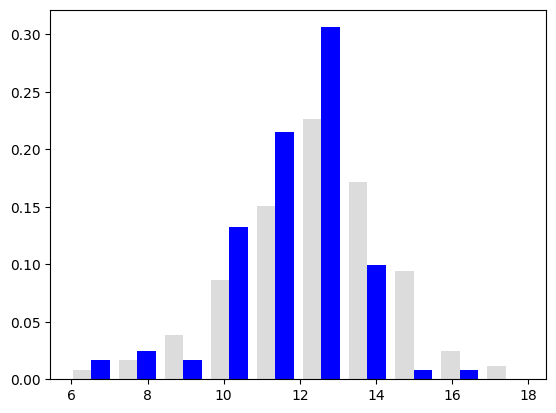

In [148]:
# plot negro in news as compared against negro in literature fiction
reference = data.loc[(data.loc[:,'person'].isin(groups['negro'])==True) & (data.loc[:,'AvNLL_bigrams'].isna()==False), 'AvNLL_bigrams']
plt.hist([reference, news['AvNLL_bigrams']], density=True, color=['gainsboro', 'blue'])

In [153]:
# 2 student t distributions
def estimator(scores, scores_):
    with pm.Model() as model:
       
        
        ## terms
        mu = pm.Normal('mu', 0, 5)
        nu = pm.Exponential('nu', 1)
        sigma = pm.Exponential('sigma', 1)
        pm.StudentT("S", mu=mu, nu=nu, sigma=sigma, observed=scores)
        
        ## reference
        mu_ = pm.Normal('mu_', 0, 10)
        nu_ = pm.Exponential('nu_', 1)
        sigma_ = pm.Exponential('sigma_', 1)
        pm.StudentT("S_", mu=mu_, nu=nu_, sigma=sigma_, observed=scores_)
        
        trace=pm.sample()
        
    return model, trace

scores = news.loc[:, 'AvNLL_bigrams'].values
scores_ = data.loc[(data.loc[:, 'person'].isin(groups['negro'])==True) & (data.loc[:, 'AvNLL_bigrams'].isna()==False), 'AvNLL_bigrams'].values

model, trace = estimator(scores, scores_)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


('-6.979E-01', '-1.362E-01')

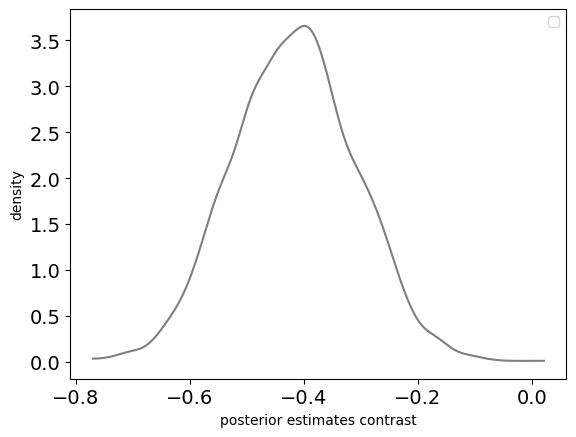

In [154]:
# size effect factor as per krutchke

# get contrasts
mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
mu_ = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
sigma_ = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

pooled = np.sqrt((sigma**2 + sigma_**2)/2)

pc = (mu-mu_)/pooled
az.plot_dist(pc, color=f'C{i}', kind='kde')

plt.xlabel(f"posterior estimates contrast")
plt.ylabel("density")
plt.legend()

compat_interval(pc, 0.99)